Has implemented a backend system using Flask for their flight fare prediction app. This system includes multiple predictive models, loaded from serialized files, that estimate various components contributing to the overall flight fare prediction. The user inputs data, which is then processed to estimate values such as base fare, total travel distance, and more, using specific models for each. The final fare prediction is also computed and returned via an API endpoint. The user employs custom transformers within their pipeline to handle specific data types and features efficiently.

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import joblib

In [2]:
# Cell 1: Define Custom Transformers

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]]

class BoolSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]].astype(float)
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, dtype=None):
        self.key = key
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.dtype:
            return X[[self.key]].astype(self.dtype)
        return X[[self.key]]


In [3]:
pd.set_option('display.max_columns', None)


In [4]:
dataset = pd.read_pickle('train.pkl')
dataset["distinct_airlines"] = dataset["distinct_airlines"].apply(lambda x: list(x)[0] if x and isinstance(x, set) else None)

In [5]:
dataset.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,days_until_flight,days_since_last_search,fare_change,seats_change,weighted_fare_change,weighted_seats_change,is_search_weekend,is_flight_weekend,Multiple_Carriers,distinct_airlines,combination_code,journeyStartTime,searchDayName,flightDayName,searchDay,flightDay
84572,20dc57dc714100c3acf0fc3400df937c,2022-06-24,2022-06-25,SFO,LGA,MA0QA0MQ,PT12H19M,1.0,0,0,0,714.42,797.2,2.0,2897.0,1656217800||1656253800,2022-06-25T21:30:00.000-07:00||2022-06-26T10:3...,1656234540||1656262140,2022-06-26T05:09:00.000-04:00||2022-06-26T12:4...,ATL||LGA,SFO||ATL,Delta||Delta,DL||DL,Boeing 737-900||Airbus A320,16740||8340,2135||762,coach||coach,1,9.0,44.0,-7.0,4.888889,-0.777778,0,1,0,Delta,4,21.500000,Friday,Saturday,4,5
21171,1eb522898e3c567b7d62a9d8d7e61152,2022-05-08,2022-06-23,SFO,BOS,UAA0OHEN,PT5H37M,1.0,0,0,1,524.65,578.6,9.0,2698.0,1656046020,2022-06-23T21:47:00.000-07:00,1656066240,2022-06-24T06:24:00.000-04:00,BOS,SFO,United,UA,Boeing 737 MAX 9,20220,2698,coach,46,1.0,0.0,0.0,0.000000,0.000000,1,0,0,United,10,21.783333,Sunday,Thursday,6,3
47459,86f3b8bf39cfea9b09a0e46fa75d6e16,2022-07-06,2022-07-31,SFO,EWR,KH0OASMN,PT5H50M,0.0,0,0,1,478.14,528.6,7.0,2566.0,1659291000,2022-07-31T11:10:00.000-07:00,1659312000,2022-07-31T20:00:00.000-04:00,EWR,SFO,Alaska Airlines,AS,Boeing 737-900,21000,2566,coach,25,1.0,-100.0,0.0,-100.000000,0.000000,0,1,0,Alaska Airlines,1,11.166667,Wednesday,Sunday,2,6
106870,e0eb783f205cbc64edaa1f186ada7bba,2022-08-24,2022-09-17,SFO,CLT,SAA2AFEN,PT10H21M,0.0,0,0,0,188.84,226.6,9.0,3111.0,1663423200||1663452840,2022-09-17T07:00:00.000-07:00||2022-09-17T18:1...,1663442460||1663460460,2022-09-17T15:21:00.000-04:00||2022-09-17T20:2...,EWR||CLT,SFO||EWR,United||United,UA||UA,BOEING 777-300ER||Boeing 737-900,19260||7620,2566||545,coach||coach,24,1.0,0.0,0.0,0.000000,0.000000,0,1,0,United,10,7.000000,Wednesday,Saturday,2,5
51925,65e124bd8ce6db3fafbf41c3f554caef,2022-04-26,2022-05-06,SFO,ORD,VAA7OKEN,PT4H15M,1.0,0,0,1,282.79,318.6,1.0,1847.0,1651886700,2022-05-06T18:25:00.000-07:00,1651902000,2022-05-07T00:40:00.000-05:00,ORD,SFO,United,UA,Boeing 737-900,15300,1847,coach,10,1.0,-24.0,-8.0,-24.000000,-8.000000,0,0,0,United,10,18.416667,Tuesday,Friday,1,4


In [6]:
def parse_duration(duration):
    hours = 0
    minutes = 0
    
    # Check if the duration contains hours
    if 'H' in duration:
        hours = int(duration.split('H')[0].split('T')[-1])
    
    # Check if the duration contains minutes
    if 'M' in duration:
        minutes = int(duration.split('M')[0].split('H')[-1] if 'H' in duration else duration.split('T')[-1])
    
    # Convert total duration to hours as a decimal
    total_hours = hours + minutes / 60
    return total_hours

In [7]:
dataset['totalTravelDuration'] = dataset['travelDuration'].apply(parse_duration)


In [8]:
test_dataset = pd.read_pickle('test.pkl')
test_dataset["distinct_airlines"] = test_dataset["distinct_airlines"].apply(lambda x: list(x)[0] if x and isinstance(x, set) else None)
test_dataset['totalTravelDuration'] = test_dataset['travelDuration'].apply(parse_duration)

In [9]:
dataset.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,days_until_flight,days_since_last_search,fare_change,seats_change,weighted_fare_change,weighted_seats_change,is_search_weekend,is_flight_weekend,Multiple_Carriers,distinct_airlines,combination_code,journeyStartTime,searchDayName,flightDayName,searchDay,flightDay,totalTravelDuration
84572,20dc57dc714100c3acf0fc3400df937c,2022-06-24,2022-06-25,SFO,LGA,MA0QA0MQ,PT12H19M,1.0,0,0,0,714.42,797.2,2.0,2897.0,1656217800||1656253800,2022-06-25T21:30:00.000-07:00||2022-06-26T10:3...,1656234540||1656262140,2022-06-26T05:09:00.000-04:00||2022-06-26T12:4...,ATL||LGA,SFO||ATL,Delta||Delta,DL||DL,Boeing 737-900||Airbus A320,16740||8340,2135||762,coach||coach,1,9.0,44.0,-7.0,4.888889,-0.777778,0,1,0,Delta,4,21.500000,Friday,Saturday,4,5,12.316667
21171,1eb522898e3c567b7d62a9d8d7e61152,2022-05-08,2022-06-23,SFO,BOS,UAA0OHEN,PT5H37M,1.0,0,0,1,524.65,578.6,9.0,2698.0,1656046020,2022-06-23T21:47:00.000-07:00,1656066240,2022-06-24T06:24:00.000-04:00,BOS,SFO,United,UA,Boeing 737 MAX 9,20220,2698,coach,46,1.0,0.0,0.0,0.000000,0.000000,1,0,0,United,10,21.783333,Sunday,Thursday,6,3,5.616667
47459,86f3b8bf39cfea9b09a0e46fa75d6e16,2022-07-06,2022-07-31,SFO,EWR,KH0OASMN,PT5H50M,0.0,0,0,1,478.14,528.6,7.0,2566.0,1659291000,2022-07-31T11:10:00.000-07:00,1659312000,2022-07-31T20:00:00.000-04:00,EWR,SFO,Alaska Airlines,AS,Boeing 737-900,21000,2566,coach,25,1.0,-100.0,0.0,-100.000000,0.000000,0,1,0,Alaska Airlines,1,11.166667,Wednesday,Sunday,2,6,5.833333
106870,e0eb783f205cbc64edaa1f186ada7bba,2022-08-24,2022-09-17,SFO,CLT,SAA2AFEN,PT10H21M,0.0,0,0,0,188.84,226.6,9.0,3111.0,1663423200||1663452840,2022-09-17T07:00:00.000-07:00||2022-09-17T18:1...,1663442460||1663460460,2022-09-17T15:21:00.000-04:00||2022-09-17T20:2...,EWR||CLT,SFO||EWR,United||United,UA||UA,BOEING 777-300ER||Boeing 737-900,19260||7620,2566||545,coach||coach,24,1.0,0.0,0.0,0.000000,0.000000,0,1,0,United,10,7.000000,Wednesday,Saturday,2,5,10.350000
51925,65e124bd8ce6db3fafbf41c3f554caef,2022-04-26,2022-05-06,SFO,ORD,VAA7OKEN,PT4H15M,1.0,0,0,1,282.79,318.6,1.0,1847.0,1651886700,2022-05-06T18:25:00.000-07:00,1651902000,2022-05-07T00:40:00.000-05:00,ORD,SFO,United,UA,Boeing 737-900,15300,1847,coach,10,1.0,-24.0,-8.0,-24.000000,-8.000000,0,0,0,United,10,18.416667,Tuesday,Friday,1,4,4.250000


## Features

In [10]:
features1 = (['flightDayName', 
              'searchDayName', 
              'destinationAirport',
              'distinct_airlines', 
              'is_search_weekend', 
              'is_flight_weekend', 
              'days_until_flight', 
              'isBasicEconomy'])

added_features = (['journeyStartTime',
                   'totalTravelDuration',
                   ])

new_estimations = (['combination_code',
                    'seatsRemaining',
                    'weighted_fare_change',
                    'weighted_seats_change'
                    ])


Order:
'flightDayName', 
'searchDayName', 
'destinationAirport',
'distinct_airlines', 
'is_search_weekend', 
'is_flight_weekend', 
'days_until_flight', 
'isBasicEconomy'
'isNonStop', 
'Multiple_Carriers'
'baseFare', 
'totalTravelDistance', 
'elapsedDays'

'journeyStartTime',
'totalTravelDuration',

'combination_code',
'seatsRemaining',
'weighted_fare_change',
'weighted_seats_change'


In [11]:
categorical_tbe = ['isNonStop', 'Multiple_Carriers']
numerical_tbe = ['baseFare', 'totalTravelDistance', 'elapsedDays']

features = features1 + categorical_tbe + numerical_tbe + added_features + new_estimations

target = "totalFare"
X_train = dataset[features]
y_train = dataset[target]

X_test = test_dataset[features]
y_test = test_dataset[target]

## Pipelines

In [12]:
# Pipeline Setup for Each Feature
days_until_flight_pipe = Pipeline([
    ('selector', ColumnSelector(key='days_until_flight')),
    ('standard', StandardScaler())
])

is_search_weekend_pipe = Pipeline([
    ('selector', ColumnSelector(key='is_search_weekend')),
    ('standard', StandardScaler())
])

is_flight_weekend_pipe = Pipeline([
    ('selector', ColumnSelector(key='is_flight_weekend')),
    ('standard', StandardScaler())
])

search_day_pipe = Pipeline([
    ('selector', ColumnSelector(key='searchDayName')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

flight_day_pipe = Pipeline([
    ('selector', ColumnSelector(key='flightDayName')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

is_basic_economy_pipe = Pipeline([
    ('selector', ColumnSelector(key='isBasicEconomy')),
    ('standard', StandardScaler())
])

distinct_airlines_pipiline = Pipeline([
    ('selector', ColumnSelector(key='distinct_airlines', dtype='str')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

destination_airport_pipe = Pipeline([
    ('selector', ColumnSelector(key='destinationAirport', dtype='str')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

baseFare_pipe = Pipeline([
    ('selector', NumberSelector(key='baseFare')),
    ('standard', StandardScaler())
])

totalTravelDistance_pipe = Pipeline([
    ('selector', NumberSelector(key='totalTravelDistance')),
    ('standard', StandardScaler())
])

elapsedDays_pipe = Pipeline([
    ('selector', NumberSelector(key='elapsedDays')),
    ('standard', StandardScaler())
])

isNonStop_pipe = Pipeline([
    ('selector', BoolSelector(key='isNonStop')),
    ('standard', StandardScaler())
])

Multiple_Carriers_pipe = Pipeline([
    ('selector', BoolSelector(key='Multiple_Carriers')),
    ('standard', StandardScaler())
])

- New pipelines

In [13]:
journeyStartTime_pipe = Pipeline([
    ('selector', ColumnSelector(key='journeyStartTime')),
    ('standard', StandardScaler())
])

totalTravelDuration_pipe = Pipeline([
    ('selector', ColumnSelector(key='totalTravelDuration')),
    ('standard', StandardScaler())
])

combination_code_pipe = Pipeline([
    ('selector', ColumnSelector(key='combination_code')),
    ('standard', StandardScaler())
])

seatsRemaining_pipe = Pipeline([
    ('selector', ColumnSelector(key='seatsRemaining')),
    ('standard', StandardScaler())
])

weighted_fare_change_pipe = Pipeline([
    ('selector', ColumnSelector(key='weighted_fare_change')),
    ('standard', StandardScaler())
])

weighted_seats_change_pipe = Pipeline([
    ('selector', ColumnSelector(key='weighted_seats_change')),
    ('standard', StandardScaler())
])



In [14]:
combined_features = FeatureUnion([
    ('days_until_flight', days_until_flight_pipe),
    ('is_search_weekend', is_search_weekend_pipe),
    ('is_flight_weekend', is_flight_weekend_pipe),
    ('search_day', search_day_pipe),
    ('flight_day', flight_day_pipe),
    ('is_basic_economy', is_basic_economy_pipe),
    ('distinct_airlines', distinct_airlines_pipiline),
    ('destination_airport', destination_airport_pipe),
    ('baseFare', baseFare_pipe),
    ('totalTravelDistance', totalTravelDistance_pipe),
    ('elapsedDays', elapsedDays_pipe),
    ('isNonStop', isNonStop_pipe),
    ('Multiple_Carriers', Multiple_Carriers_pipe),
    ('journeyStartTime', journeyStartTime_pipe),
    ('totalTravelDuration', totalTravelDuration_pipe),
    ('combination_code', combination_code_pipe),
    ('seatsRemaining', seatsRemaining_pipe),
    ('weighted_fare_change', weighted_fare_change_pipe),
    ('weighted_seats_change', weighted_seats_change_pipe)
])

In [15]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Elastic Net': ElasticNet(),
    'GBM': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}


In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Model LR

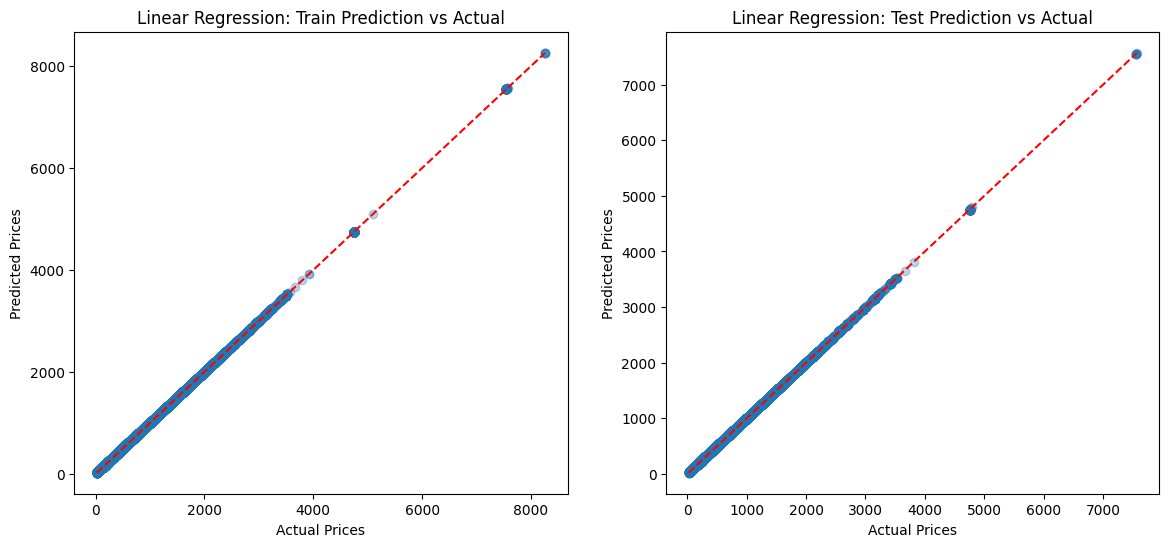

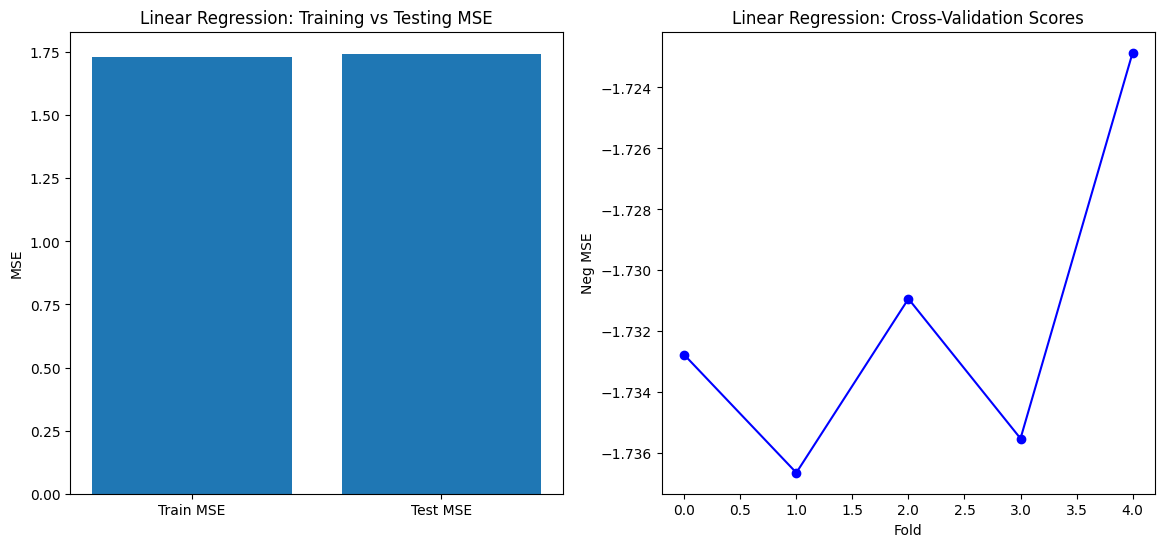

In [21]:
# Define the Linear Regression pipeline
lr_pipeline = Pipeline([
    ('features', combined_features),
    ('regressor', LinearRegression())
])

# Fit the model on the training data
lr_pipeline.fit(X_train, y_train)

# Predictions for training and test sets
predictions_train_lr = lr_pipeline.predict(X_train)
predictions_test_lr = lr_pipeline.predict(X_test)

# Compute the MSE for the training and test sets
mse_train_lr = mean_squared_error(y_train, predictions_train_lr)
mse_test_lr = mean_squared_error(y_test, predictions_test_lr)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(lr_pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Plotting training and testing predictions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_train_lr, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title('Linear Regression: Train Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_test_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Test Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Plotting MSE and Cross-Validation results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(['Train MSE', 'Test MSE'], [mse_train_lr, mse_test_lr])
plt.title('Linear Regression: Training vs Testing MSE')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(cv_scores_lr, marker='o', linestyle='-', color='b')
plt.title('Linear Regression: Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Neg MSE')
plt.show()

## Ridge

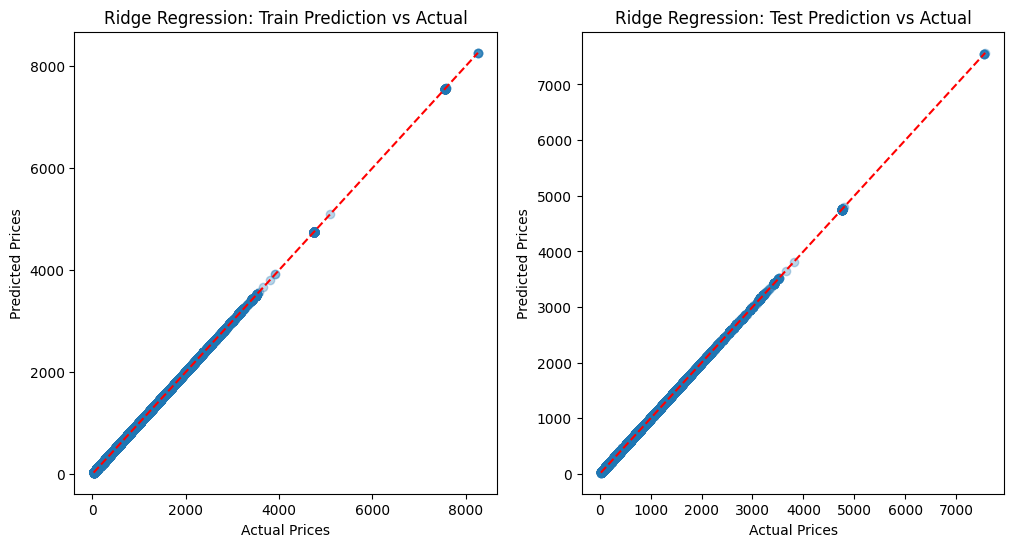

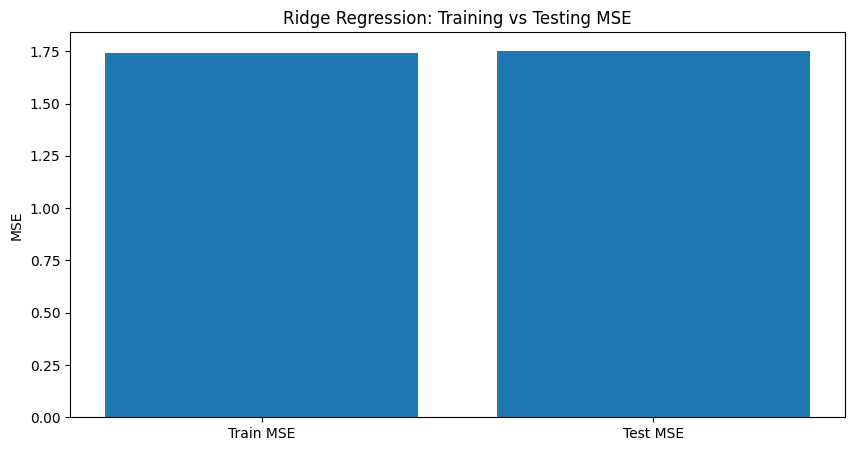

In [23]:
# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Ridge Pipeline with hyperparameter tuning
ridge_params = {'regressor__alpha': [0.1, 1.0, 10.0]}
ridge_pipeline = Pipeline([
    ('features', combined_features),
    ('regressor', Ridge())
])
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Best estimator for predictions
best_ridge = ridge_grid.best_estimator_
predictions_train_ridge = best_ridge.predict(X_train)
predictions_test_ridge = best_ridge.predict(X_test)
mse_train_ridge = mean_squared_error(y_train, predictions_train_ridge)
mse_test_ridge = mean_squared_error(y_test, predictions_test_ridge)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_train_ridge, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title('Ridge Regression: Train Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_test_ridge, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Ridge Regression: Test Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(['Train MSE', 'Test MSE'], [mse_train_ridge, mse_test_ridge])
plt.title('Ridge Regression: Training vs Testing MSE')
plt.ylabel('MSE')
plt.show()


## Lasso

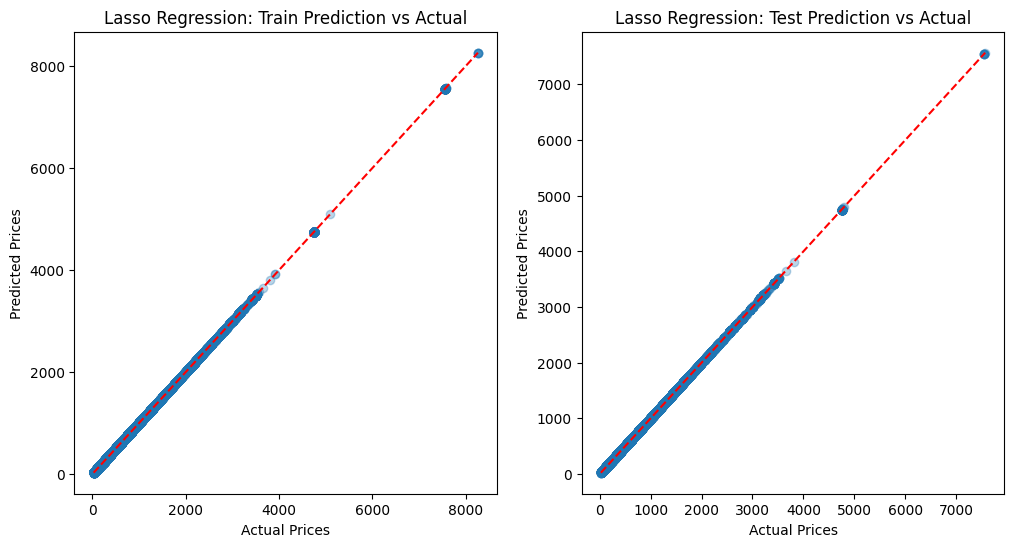

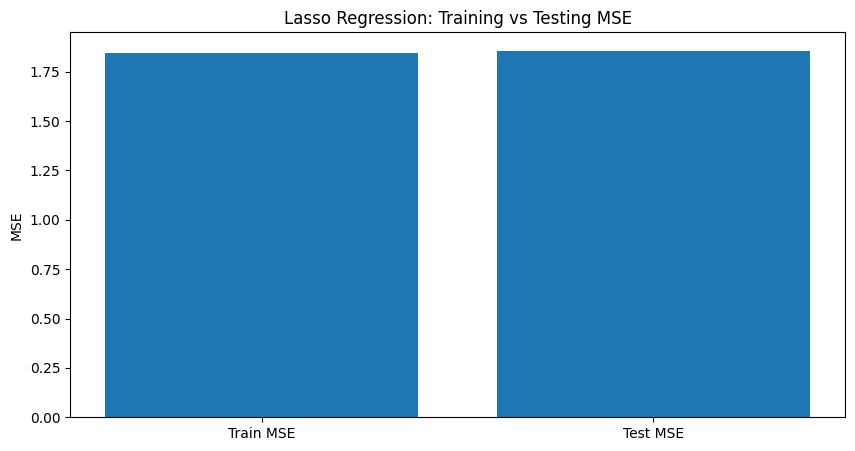

In [26]:
# Ridge Regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Ridge Pipeline with hyperparameter tuning
lasso_params = {'regressor__alpha': [0.1, 1.0, 10.0]}
lasso_pipeline = Pipeline([
    ('features', combined_features),
    ('regressor', Lasso())
])

lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Best estimator for predictions
best_lasso = lasso_grid.best_estimator_
predictions_train_lasso = best_lasso.predict(X_train)
predictions_test_lasso = best_lasso.predict(X_test)
mse_train_lasso = mean_squared_error(y_train, predictions_train_lasso)
mse_test_lasso = mean_squared_error(y_test, predictions_test_lasso)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_train_lasso, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title('Lasso Regression: Train Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_test_lasso, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Lasso Regression: Test Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(['Train MSE', 'Test MSE'], [mse_train_lasso, mse_test_lasso])
plt.title('Lasso Regression: Training vs Testing MSE')
plt.ylabel('MSE')
plt.show()



## Elastic

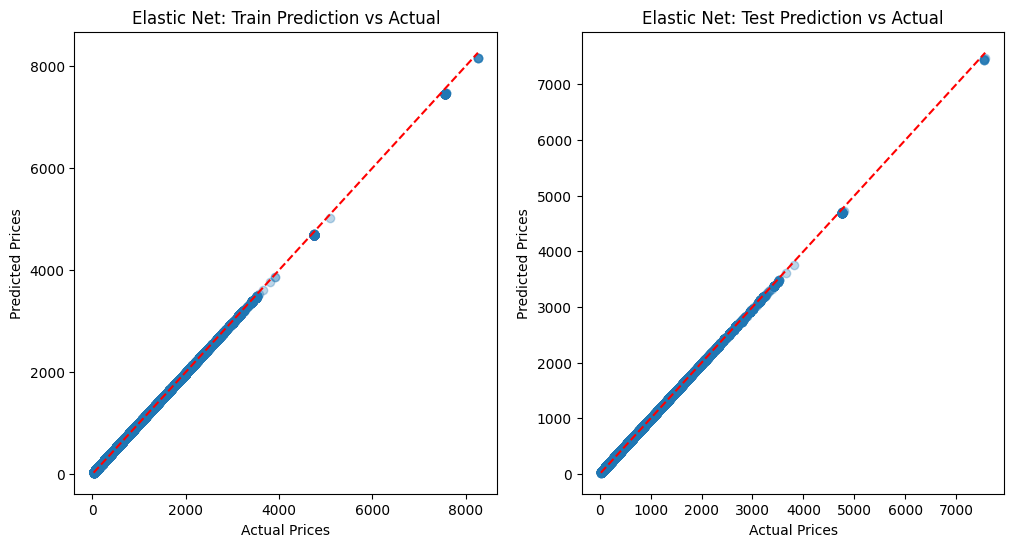

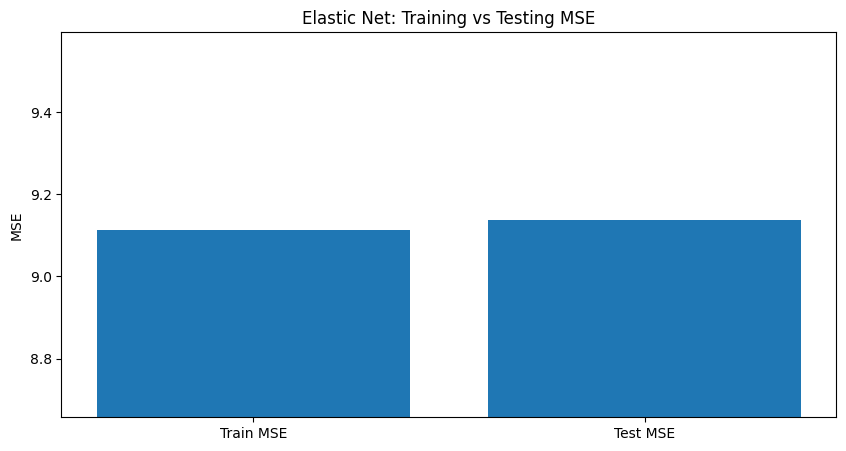

In [30]:
from sklearn.linear_model import ElasticNet

elastic_pipeline = Pipeline([
    ('features', combined_features),
    ('scaler', StandardScaler(with_mean=False)),  # Add a scaler to standardize features
    ('regressor', ElasticNet())
])

elastic_params = {'regressor__alpha': [0.1, 1.0, 10.0], 'regressor__l1_ratio': [0.1, 0.5, 0.9]}
elastic_grid = GridSearchCV(elastic_pipeline, elastic_params, cv=5, scoring='neg_mean_squared_error')
elastic_grid.fit(X_train, y_train)

# Best estimator for predictions
best_elastic = elastic_grid.best_estimator_
predictions_train_elastic = best_elastic.predict(X_train)
predictions_test_elastic = best_elastic.predict(X_test)
mse_train_elastic = mean_squared_error(y_train, predictions_train_elastic)
mse_test_elastic = mean_squared_error(y_test, predictions_test_elastic)

# Plotting prediction vs actual with scaled axes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_train_elastic, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title('Elastic Net: Train Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_test_elastic, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Elastic Net: Test Prediction vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# MSE bar chart with tighter y-axis limits to zoom in on values
plt.figure(figsize=(10, 5))
plt.bar(['Train MSE', 'Test MSE'], [mse_train_elastic, mse_test_elastic])
plt.ylim(min(mse_train_elastic, mse_test_elastic) * 0.95, max(mse_train_elastic, mse_test_elastic) * 1.05)  # Tighten the y-axis to enhance visibility
plt.title('Elastic Net: Training vs Testing MSE')
plt.ylabel('MSE')
plt.show()




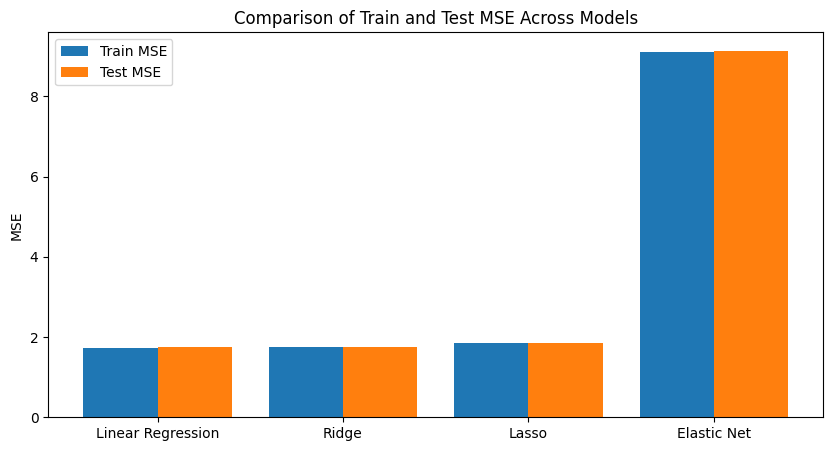

In [32]:
# Assuming mse_train_lr, mse_test_lr, mse_train_ridge, mse_test_ridge, ... are collected
models = ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net']
train_mses = [mse_train_lr, mse_train_ridge, mse_train_lasso, mse_train_elastic]
test_mses = [mse_test_lr, mse_test_ridge, mse_test_lasso, mse_test_elastic]

plt.figure(figsize=(10, 5))
x = np.arange(len(models))
plt.bar(x - 0.2, train_mses, 0.4, label='Train MSE')
plt.bar(x + 0.2, test_mses, 0.4, label='Test MSE')
plt.xticks(x, models)
plt.title('Comparison of Train and Test MSE Across Models')
plt.ylabel('MSE')
plt.legend()
plt.show()


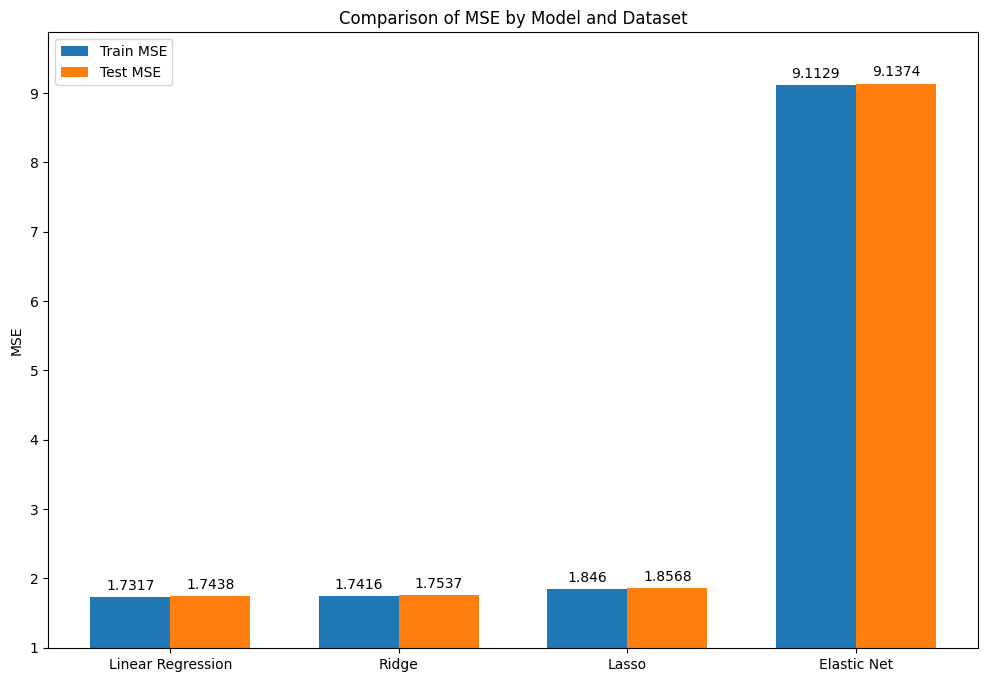

In [31]:
# Assume these MSE values are calculated from previous steps
train_mses = {
    'Linear Regression': mse_train_lr,
    'Ridge': mse_train_ridge,
    'Lasso': mse_train_lasso,
    'Elastic Net': mse_train_elastic
}

test_mses = {
    'Linear Regression': mse_test_lr,
    'Ridge': mse_test_ridge,
    'Lasso': mse_test_lasso,
    'Elastic Net': mse_test_elastic
}

# Labels for the bar chart
labels = list(train_mses.keys())

# Values for the bar chart
train_values = [train_mses[model] for model in labels]
test_values = [test_mses[model] for model in labels]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Creating bars
rects1 = ax.bar(x - width/2, train_values, width, label='Train MSE')
rects2 = ax.bar(x + width/2, test_values, width, label='Test MSE')

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Comparison of MSE by Model and Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Zooming in on the y-axis to better highlight differences
min_mse = min(train_values + test_values)
max_mse = max(train_values + test_values)
ax.set_ylim([min_mse - (max_mse - min_mse)*0.1, max_mse + (max_mse - min_mse)*0.1])

plt.show()


In [ ]:
############
############

## Export Best Model

In [33]:

joblib.dump(best_ridge, f'Models/fare_predicition_model.pkl')


['Models/fare_predicition_model.pkl']